# Clasificador de estrategias
## k-Medoids

In [83]:
import numpy as np
import pandas as pd
import matplotlib as plt
from math import sqrt
from statistics import stdev
import datetime as dt
import random

In [84]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
import pandas as pd

from math import sqrt
from matplotlib import pyplot as plt

# k medoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.elbow import elbow
from pyclustering.cluster import cluster_visualizer

from pyclustering.cluster.silhouette import silhouette

In [85]:
# parameters
n = (2520) # number of observation to choose

In [86]:
# Load the data
path = '/Archivos/MIDS/GitHub/models/PI_2/Features.csv'
#Archivos/MIDS/GitHub/models/PI_2/Features.csv
Features = pd.read_csv('Rentabilidad de estrategias base 100.csv', index_col=0)

In [87]:
df = Features.tail(n)

In [15]:
# calculamos el retorno y volatilidad.

returns = df.pct_change().mean()
returns = pd.DataFrame(returns)
returns.columns = ['Returns'] 
returns['Volatility'] = df.pct_change().std()

#format the data as a numpy array to feed into the kmedoids algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
data

array([[ 0.00187538,  0.03380039],
       [-0.00137904,  0.03812399],
       [ 0.00049633,  0.0187305 ],
       [ 0.00201356,  0.0354735 ],
       [-0.00126166,  0.0366834 ],
       [ 0.0007519 ,  0.01908987],
       [ 0.00147875,  0.03629711],
       [-0.00179648,  0.03555102],
       [-0.00031773,  0.01786201],
       [ 0.0015662 ,  0.0365361 ],
       [-0.00170903,  0.03531205],
       [-0.00014283,  0.01788842],
       [ 0.00156968,  0.03574369],
       [-0.00170555,  0.03611822],
       [-0.00013587,  0.01790574],
       [ 0.0014959 ,  0.03611611],
       [-0.00177933,  0.03596058],
       [-0.00028342,  0.01874603],
       [ 0.00149113,  0.03656556],
       [-0.0017841 ,  0.03548397],
       [-0.00029297,  0.01867204],
       [ 0.0013766 ,  0.03630006],
       [-0.00189863,  0.0355938 ],
       [-0.00052203,  0.01804347],
       [ 0.00172749,  0.03541604],
       [-0.00154774,  0.0372119 ],
       [ 0.00017975,  0.02084185]])

In [16]:
def compute_distances(points):
    n = points.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i,j] = np.linalg.norm(points[i,:] - points[j,:])
    return distances

distances = compute_distances(data)
print(distances.shape)

(27, 27)


In [88]:
def strategy_kmedoids(df, n =2520, K = 3):
    
    def compute_distances(points):
        n = points.shape[0]
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i,j] = np.linalg.norm(points[i,:] - points[j,:])
        return distances
    
    def cluster(distances, k=3):

        m = distances.shape[0] # number of points

        # Pick k random medoids.
        curr_medoids = np.array([-1]*k)
        while not len(np.unique(curr_medoids)) == k:
            curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
        old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
        new_medoids = np.array([-1]*k)

        # Until the medoids stop updating, do the following:
        while not ((old_medoids == curr_medoids).all()):
            # Assign each point to cluster with closest medoid.
            clusters = assign_points_to_clusters(curr_medoids, distances)

            # Update cluster medoids to be lowest cost point.
            for curr_medoid in curr_medoids:
                cluster = np.where(clusters == curr_medoid)[0]
                new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

            old_medoids[:] = curr_medoids[:]
            curr_medoids[:] = new_medoids[:]

        return clusters, curr_medoids

    def assign_points_to_clusters(medoids, distances):
        distances_to_medoids = distances[:,medoids]
        clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
        assert (clusters[medoids] == medoids).all()
        return clusters

    def compute_new_medoid(cluster, distances):
        mask = np.ones(distances.shape)
        mask[np.ix_(cluster,cluster)] = 0.
        cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
        costs = cluster_distances.sum(axis=1)
        return costs.argmin(axis=0, fill_value=10e9)

    df = df.tail(n)
    returns = df.pct_change().mean()
    returns = pd.DataFrame(returns)
    returns.columns = ['Returns'] 
    returns['Volatility'] = df.pct_change().std()

    data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T  

    distances = compute_distances(data)    

    _clusters, medoids = cluster(distances, K)

    results=pd.DataFrame({'Returns': data[:, 0], 
                   'Volatility': data[:, 1],
                   'ClusterkMedoids':_clusters,
                   'strategies': df.columns,
                  })

    medoidsclusters =[] 

    for i in results.ClusterkMedoids.unique():
        l = results.loc[results['ClusterkMedoids'] == i].index.values.astype(int).tolist()
        dfexp=df.pct_change().iloc[: , l].sum(axis = 1, skipna = True)
        r = dfexp.mean()
        s = stdev(dfexp)

        medoidsclusters.append(r/s)
    medoidsclusters = np.asanyarray(medoidsclusters)    

    selection = medoidsclusters.argmax()

    cond = results['ClusterkMedoids'] == results.ClusterkMedoids.unique()[selection]

    results['selection'] = np.where(cond, 1, 0)    

    return results['strategies'][results['selection'] == 1].values.tolist()

In [97]:
strategy_kmedoids(df)

['LA1', 'LA101', 'LA2', 'LA3', 'LA44', 'LA53', 'LA54', 'LA6', 'LAMAR']

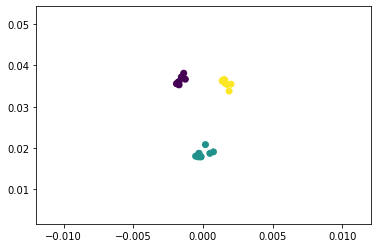

In [59]:
_ = plt.scatter(data[:,0], data[:,1], c=clusters)

['LSA1', 'LSA101', 'LSAMAR']

In [81]:
results

,Returns,Volatility,ClusterkMedoids,strategies,selection
0,0.001875,0.033800,21,LA1,0
1,-0.001379,0.038124,21,SA1,0
2,0.000496,0.018730,5,LSA1,1
3,0.002014,0.035474,21,LA101,0
4,-0.001262,0.036683,21,SA101,0
5,0.000752,0.019090,5,LSA101,1
6,0.001479,0.036297,21,LA2,0
7,-0.001796,0.035551,21,SA2,0
8,-0.000318,0.017862,14,LSA2,0
9,0.001566,0.036536,21,LA3,0


In [18]:
def strategy_kmedoids(df, n =2520, K = 4):

    df = df.tail(n)
    returns = df.pct_change().mean()
    returns = pd.DataFrame(returns)
    returns.columns = ['Returns'] 
    returns['Volatility'] = df.pct_change().std()

    data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
   

    initial_medoids = random.sample(range(0,  len(df.columns)), K)
        
    print(initial_medoids)
    # Create instance of K-Medoids algorithm.
    kmedoids_instance = kmedoids(data, initial_medoids)
    # Run cluster analysis and obtain results.
    kmedoids_instance.process()
    _clusters = kmedoids_instance.get_clusters()

    ordered_elements = []
    for idx, val in enumerate(_clusters):
        for i in val:
            ordered_elements.append((i,idx))
    
    labelsKMedoids = [x[1] for x in sorted(ordered_elements, key=lambda tup: tup[0])]    
    

    results=pd.DataFrame({'Returns': data[:, 0], 
                   'Volatility': data[:, 1],
                   'ClusterkMedoids':labelsKMedoids,
                   'strategies': df.columns,
                  })

    medoidsclusters =[] 

    for i in range(results['ClusterkMedoids'].nunique()):
        l = results.loc[results['ClusterkMedoids'] == i].index.values.astype(int).tolist()
        dfexp=df.pct_change().iloc[: , l].sum(axis = 1, skipna = True)
        r = dfexp.mean()
        s = stdev(dfexp)

        medoidsclusters.append(r/s)
    medoidsclusters = np.asanyarray(medoidsclusters)    
    selection = medoidsclusters.argmax()

    cond = results['ClusterkMedoids'] == selection

    results['selection'] = np.where(cond, 1, 0)    
    
    return results['strategies'][results['selection'] == 1].values.tolist()

In [26]:
strategy_kmedoids(df)

[7, 21, 24, 3]


['LA101']

In [27]:
# Basic summary statistics
data_train = df.T.values
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 27
Number of unique classes: 27
Time series length: 2519


In [44]:
Features.head(5)

,LA1,SA1,LSA1,LA101,SA101,LSA101,LA2,SA2,LSA2,LA3,...,LSA53,LA54,SA54,LSA54,LA6,SA6,LSA6,LAMAR,SAMAR,LSAMAR
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-31,112.315749,101.786622,114.102371,114.322571,103.793443,118.116014,99.449679,88.920552,88.370231,104.354609,...,81.883986,96.206557,85.677429,81.883986,104.354609,93.825481,98.180090,96.206557,85.677429,81.883986
2008-11-03,108.673546,102.316747,110.996498,106.226580,100.349511,105.832219,100.307494,93.034200,93.220667,103.600199,...,90.399733,99.398751,91.744855,90.399733,103.600199,96.678447,100.455694,99.398751,91.744855,90.399733
2008-11-04,125.214699,88.014545,112.375738,127.844695,91.470217,118.005653,112.245048,76.940813,88.189179,119.390981,...,80.001433,108.193919,73.073908,80.001433,119.390981,83.184769,101.746311,108.193919,73.073908,80.001433
2008-11-05,99.808765,100.439696,105.439075,98.080355,101.646659,103.660622,96.722894,92.773882,94.141451,99.195744,...,89.726586,96.156896,90.086712,89.726586,99.195744,97.735318,102.333012,96.156896,90.086712,89.726586
2008-11-06,80.598195,117.785421,103.353926,75.685445,115.555927,94.176416,81.308015,111.866757,98.512300,79.377214,...,97.935928,82.998843,110.656415,97.935928,79.377214,113.898740,98.811468,82.998843,110.656415,97.935928


In [46]:
kmin, kmax = 1, 10
elbow_instance = elbow(data, kmin, kmax)

In [47]:
elbow_instance.process()
amount_clusters = elbow_instance.get_amount()  # most probable amount of clusters
wce = elbow_instance.get_wce()  # total within-cluster errors for each K

In [48]:
amount_clusters

2

[[4, 1, 13, 25], [8, 2, 5, 11, 14, 17, 20, 23, 26], [10, 7, 16, 19, 22], [15, 0, 3, 6, 9, 12, 18, 21, 24]]


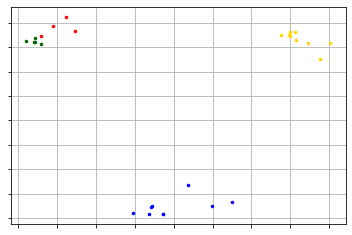

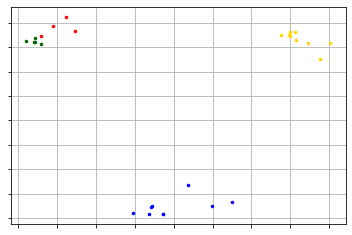

In [49]:
initial_medoids = [4, 8, 10, 15]
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(data, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
print(clusters)
# Display clusters.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, data)
visualizer.show()

In [50]:
# Calculate silhouette_score
print('\n Silhouette_score PI_STD:')
score = silhouette(data, clusters).process().get_score()
print(score)



 Silhouette_score PI_STD:
[0.36151185518162615, 0.6473447149425289, -0.822988754601975, 0.706244525696165, 0.9941581221937992, 0.9951977721474409, 0.9928843028515858, 0.9945452850789954, 0.9946326629879392, 0.9959631900489101, 0.9960170849403498, 0.9943568935984312, 0.9703327477017399, 0.9554437552813656, 0.9783119152964428, 0.8668432536230177, 0.9762355391894534, 0.9733591629143771, 0.9103512845105933, 0.6770526664848248, 0.9252578072579275, 0.8895493916083047, 0.8613336361209281, 0.9298835366576497, 0.8476047575559126, 0.877227317000752, 0.9218952426483685]


In [51]:
clusters = kmedoids_instance.get_clusters()

In [52]:
def getLabelsKMedoids(_clusters): 
    ordered_elements = []
    for idx, val in enumerate(_clusters):
        for i in val:
            ordered_elements.append((i,idx))
    return [x[1] for x in sorted(ordered_elements, key=lambda tup: tup[0])]

In [53]:
data_copy=pd.DataFrame({'Returns': data[:, 0], 'Volatility': data[:, 1]})
data_copy['ClusterkMedoids'] = getLabelsKMedoids(clusters)

data_copy

,Returns,Volatility,ClusterkMedoids
0,0.001875,0.033800,3
1,-0.001379,0.038124,0
2,0.000496,0.018730,1
3,0.002014,0.035474,3
4,-0.001262,0.036683,0
5,0.000752,0.019090,1
6,0.001479,0.036297,3
7,-0.001796,0.035551,2
8,-0.000318,0.017862,1
9,0.001566,0.036536,3


In [56]:
data_copy['ClusterkMedoids']

0     3
1     0
2     1
3     3
4     0
5     1
6     3
7     2
8     1
9     3
10    2
11    1
12    3
13    0
14    1
15    3
16    2
17    1
18    3
19    2
20    1
21    3
22    2
23    1
24    3
25    0
26    1
Name: ClusterkMedoids, dtype: int64

In [58]:
medoidsclusters =[] 
Features = Features.tail(n)
for i in range(data_copy['ClusterkMedoids'].nunique()):
    
    l = data_copy.loc[data_copy['ClusterkMedoids'] == i].index.values.astype(int).tolist()
    dfexp=Features.pct_change().iloc[: , l].sum(axis = 1, skipna = True)
    r = dfexp.mean()
    s = stdev(dfexp)
    
    medoidsclusters.append(r/s)
medoidsclusters = np.asanyarray(medoidsclusters)

In [59]:
selection = medoidsclusters.argmax()


In [60]:
cond = data_copy['ClusterkMedoids'] == selection

data_copy['selection'] = np.where(cond, 1, 0)


In [62]:
data_copy

,Returns,Volatility,ClusterkMedoids,selection
0,0.001875,0.033800,3,1
1,-0.001379,0.038124,0,0
2,0.000496,0.018730,1,0
3,0.002014,0.035474,3,1
4,-0.001262,0.036683,0,0
5,0.000752,0.019090,1,0
6,0.001479,0.036297,3,1
7,-0.001796,0.035551,2,0
8,-0.000318,0.017862,1,0
9,0.001566,0.036536,3,1


In [63]:
medoidsclusters


array([-0.04077583, -0.00435092, -0.05152708,  0.04666274])